Meaghan Woody

Spring 2025

Data cleaning

- HOLC Redlining
- LA Census maps

# 1. LA Specific HOLC Maps

In [2]:
import geopandas as gpd

# Path to your file
holc = '/Users/markwoody/Desktop/UP 213/final/geojson.json'

LAholc = gpd.read_file(holc)

LAholc.head(5)


Skipping field label_coords: unsupported OGR type: 3


,area_id,city_id,grade,fill,label,name,category_id,sheets,area,bounds,residential,commercial,industrial,geometry
0,7761,16,A,#76a865,A1,,1,1,0.000336,"[ [ 34.136969999999998, -118.46807 ], [ 34.153...",True,False,False,"MULTIPOLYGON (((-118.45744 34.15201, -118.4656..."
1,7775,16,A,#76a865,A10,,1,1,0.000181,"[ [ 34.1691, -118.11198 ], [ 34.18894000000000...",True,False,False,"MULTIPOLYGON (((-118.11151 34.18311, -118.1119..."
2,7808,16,A,#76a865,A11,,1,1,0.000060,"[ [ 34.155970000000003, -118.11301 ], [ 34.163...",True,False,False,"MULTIPOLYGON (((-118.113 34.15985, -118.10676 ..."
3,8025,16,A,#76a865,A12,,1,1,0.000259,"[ [ 34.122999999999998, -118.18331000000001 ],...",True,False,False,"MULTIPOLYGON (((-118.17123 34.12776, -118.1707..."
4,7608,16,A,#76a865,A13,,1,1,0.000133,"[ [ 34.127760000000002, -118.18619 ], [ 34.146...",True,False,False,"MULTIPOLYGON (((-118.17458 34.14194, -118.1745..."


In [6]:
print(LAholc.crs)  # Coordinate Reference System
print(LAholc.columns)  # Check what fields you have

EPSG:4326
Index(['area_id', 'city_id', 'grade', 'fill', 'label', 'name', 'category_id',
       'sheets', 'area', 'bounds', 'residential', 'commercial', 'industrial',
       'geometry'],
      dtype='object')


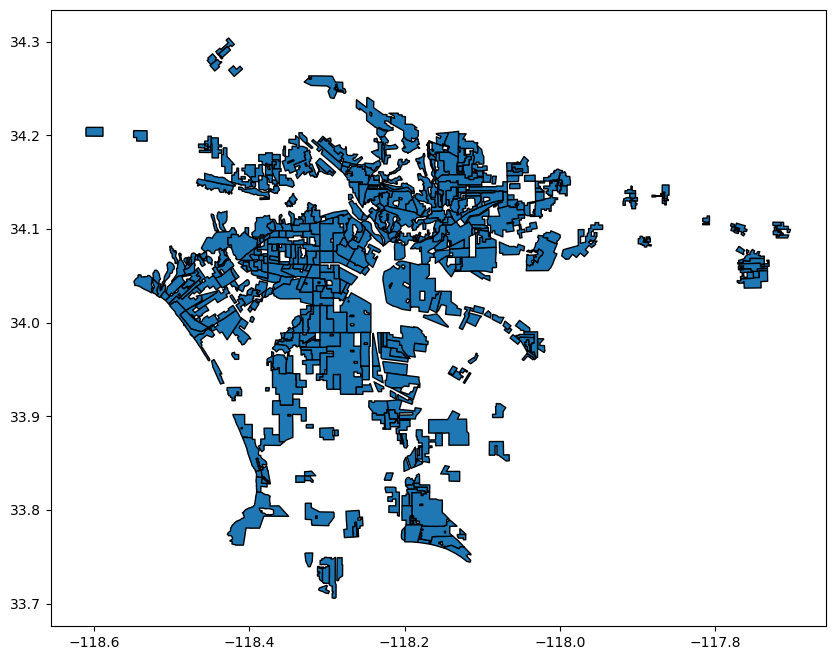

In [10]:
import matplotlib.pyplot as plt
LAholc.plot(figsize=(10, 10), edgecolor='black')
plt.show()

# 2. US HOLC maps

# 3. LA Census track

Predictor
ACS Variable
% Households Below 200% FPL
C17002
Poverty Rate
B17001 or B17021
Median Household Income
B19013
% Unemployed
B23025
% Households with Children
B11003
% Single-Parent Households
B11005
% With No High School Diploma
B15003
% Limited English Proficiency (LEP)
B16004 or B16002
% Foreign-Born / Non-Citizens
B05002 or B05001
% Renters
B25003
% Households Without a Vehicle
B25044
% Disabled Population
B18101, B18135
% Elderly Living Alone
B11007, B19037

In [55]:
import requests
import pandas as pd

# Query ACS 2021 5-Year Data for tracts in LA County (FIPS: 06, 037)
url = (
    "https://api.census.gov/data/2021/acs/acs5?"
    "get=B22010_001E,B22010_002E,B17017_002E,B17017_006E,NAME"
    "&for=tract:*&in=state:06+county:037"
)

response = requests.get(url)
data = response.json()

# Convert to DataFrame
cols = data[0]
rows = data[1:]
snapdf = pd.DataFrame(rows, columns=cols)

# Create GEOID for merge
snapdf['GEOID'] = snapdf['state'] + snapdf['county'] + snapdf['tract']

# Convert columns to numeric
for col in ['B22010_001E', 'B22010_002E', 'B17017_002E', 'B17017_006E']:
    snapdf[col] = pd.to_numeric(snapdf[col], errors='coerce')

snapdf = snapdf[['GEOID', 'B22010_001E', 'B22010_002E', 'B17017_002E', 'B17017_006E']]


In [57]:
import geopandas as gpd

# Load LA County tract shapefile
tracts = gpd.read_file('/Users/markwoody/Desktop/UP 213/final/tl_2020_06037_tract20')
tracts = tracts.rename(columns={'GEOID20': 'GEOID'})
tracts['GEOID'] = tracts['GEOID'].astype(str)

# Merge SNAP data
tracts_merged = tracts.merge(snapdf, on='GEOID', how='left')


In [59]:
import numpy as np

tracts_merged['snap_rate'] = (tracts_merged['B22010_002E'] / tracts_merged['B22010_001E']) * 100
tracts_merged['ebne_rate'] = (tracts_merged['B17017_006E'] / tracts_merged['B17017_002E']) * 100
tracts_merged['snap_gap'] = tracts_merged['snap_rate'] - tracts_merged['ebne_rate']

# Clean
tracts_merged.replace([np.inf, -np.inf], np.nan, inplace=True)


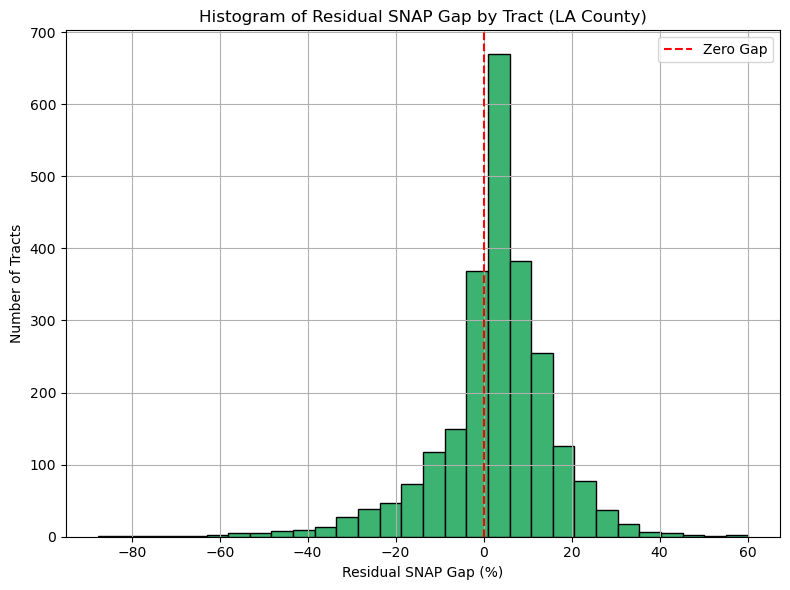

In [61]:
import matplotlib.pyplot as plt

snap_gap_clean = tracts_merged['snap_gap'].dropna()

plt.figure(figsize=(8, 6))
plt.hist(snap_gap_clean, bins=30, color='mediumseagreen', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', label='Zero Gap')
plt.title('Histogram of Residual SNAP Gap by Tract (LA County)')
plt.xlabel('Residual SNAP Gap (%)')
plt.ylabel('Number of Tracts')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [67]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load LA County tracts shapefile
tracts = gpd.read_file('/Users/markwoody/Desktop/UP 213/final/tl_2020_06037_tract20')
tracts = tracts.rename(columns={'GEOID20': 'GEOID'})
tracts['GEOID'] = tracts['GEOID'].astype(str)

# Load ACS SNAP data (if not already loaded)
# --- insert your snapdf merging block here if needed ---

# Merge SNAP data with tract geometries
tracts_merged = tracts.merge(snapdf, on='GEOID', how='left')

# Calculate metrics
tracts_merged['snap_rate'] = (tracts_merged['B22010_002E'] / tracts_merged['B22010_001E']) * 100
tracts_merged['ebne_rate'] = (tracts_merged['B17017_006E'] / tracts_merged['B17017_002E']) * 100
tracts_merged['snap_gap'] = tracts_merged['snap_rate'] - tracts_merged['ebne_rate']

# Clean up
tracts_merged.replace([np.inf, -np.inf], np.nan, inplace=True)

# Keep only valid rows
tracts_valid = tracts_merged[tracts_merged['snap_gap'].notna()]

# Plot helper function
def plot_static_map(gdf, column, title, cmap):
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(
        column=column,
        ax=ax,
        cmap=cmap,
        legend=True,
        legend_kwds={
            'label': f"{title} (%)",
            'shrink': 0.5,
            'aspect': 20
        },
        edgecolor='black',
        linewidth=0.1
    )
    ax.set_title(title, fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    plt.tight_layout()
    plt.show()

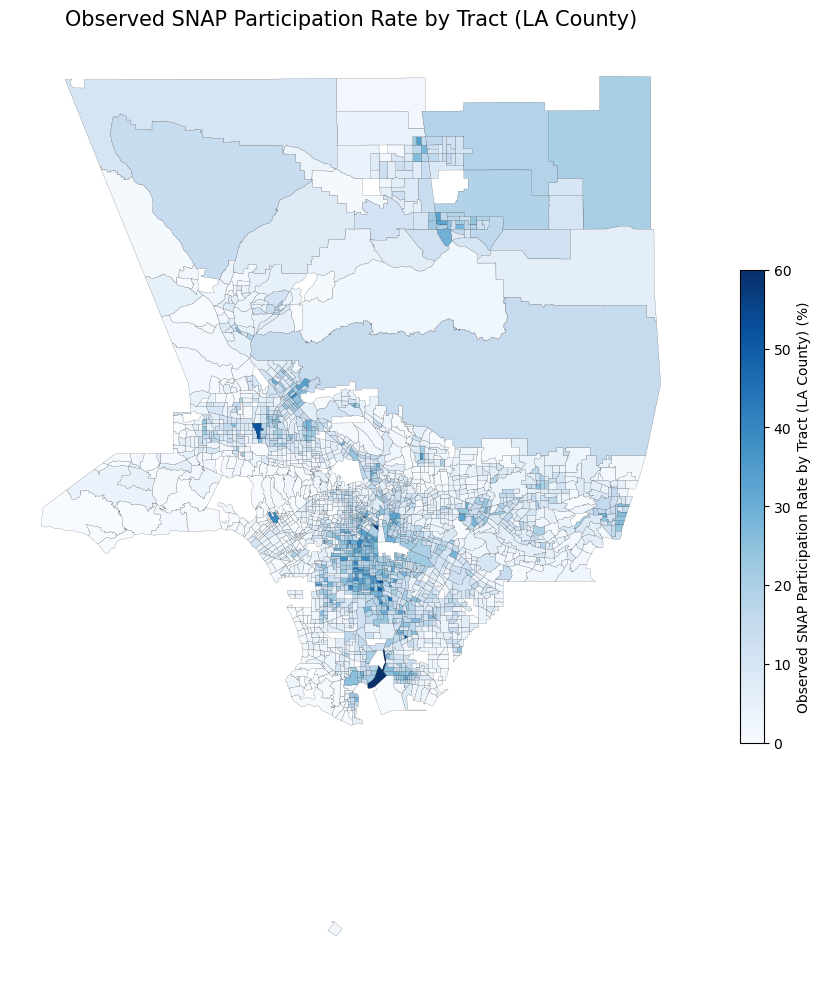

In [69]:
plot_static_map(tracts_valid, 'snap_rate', 'Observed SNAP Participation Rate by Tract (LA County)', 'Blues')

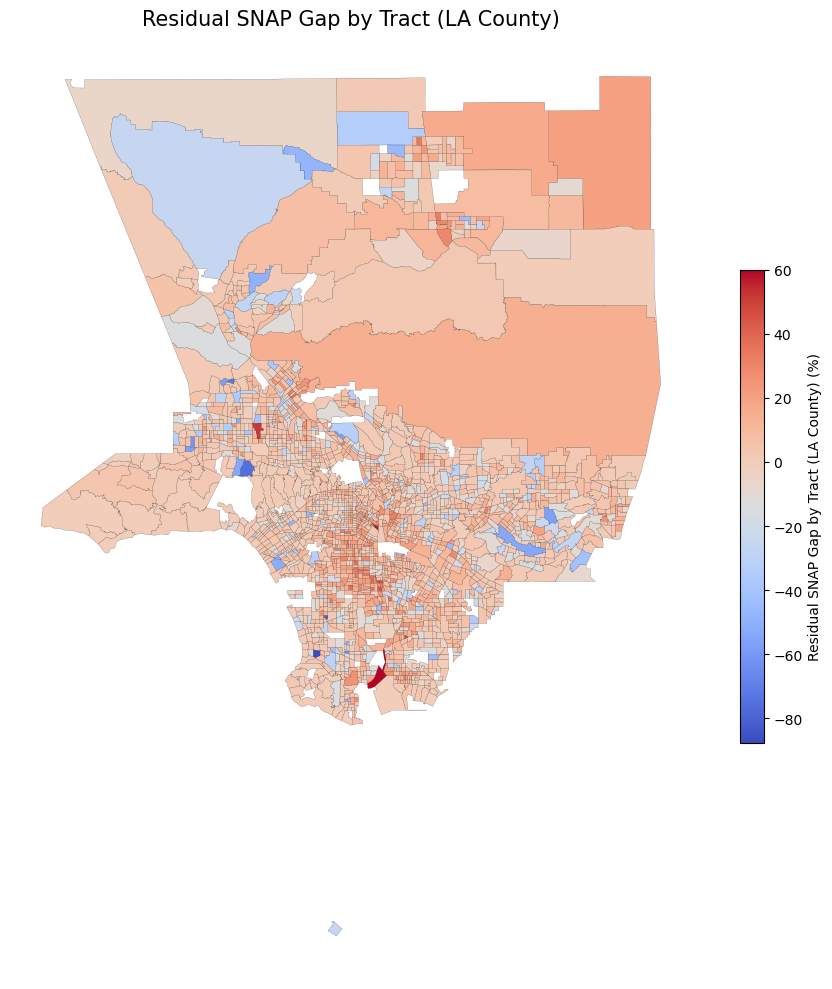

In [71]:
plot_static_map(tracts_valid, 'snap_gap', 'Residual SNAP Gap by Tract (LA County)', 'coolwarm')

In [ ]:
plot_static_map(tracts_valid, 'ebne_rate', 'EBNE Rate (Eligible But Not Enrolled) by Tract (LA County)', 'Oranges')